In [1]:
# Adapted from ProVis: https://github.com/salesforce/provis

# You might need to set to avoid crashes:
# export KMP_DUPLICATE_LIB_OK=TRUE

In [2]:
import io
import urllib

import torch
from Bio.Data import SCOPData
from Bio.PDB import PDBParser, PPBuilder
import nglview
import pandas as pd
import seaborn as sns
import numpy as np
from src.app import predict_seq
from Bio.PDB.Polypeptide import three_to_one
from abnumber import Chain
from nglview.adaptor import BiopythonStructure
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
def get_structure(pdb_id):
    resource = urllib.request.urlopen(f'https://files.rcsb.org/download/{pdb_id}.pdb')
    content = resource.read().decode('utf8')
    handle = io.StringIO(content)
    parser = PDBParser(QUIET=True)
    return parser.get_structure(pdb_id, handle)

In [4]:
POSITIONS = [
    '1', '2', '3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 
    '21', '22', '23', '24', '25', '26', '27', '29', '30', '31', '32', '33', '39', '40', '41', '42', '43', '44', 
    '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '65', 
    '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', 
    '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', 
    '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '133', '134', '135', 
    '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149'
]
len(POSITIONS)

120

In [5]:
structure = get_structure('5B8C')#5B8C, 1SY6, 5WUV
model = structure[0]
model

<Model id=0>

In [6]:
chain = model['B']
residues = [r for r in chain.get_residues() if r.resname != 'HOH'][:len(POSITIONS)]

residues[-10:]

[<Residue GLY het=  resseq=111 icode= >,
 <Residue GLN het=  resseq=112 icode= >,
 <Residue GLY het=  resseq=113 icode= >,
 <Residue THR het=  resseq=114 icode= >,
 <Residue THR het=  resseq=115 icode= >,
 <Residue VAL het=  resseq=116 icode= >,
 <Residue THR het=  resseq=117 icode= >,
 <Residue VAL het=  resseq=118 icode= >,
 <Residue SER het=  resseq=119 icode= >,
 <Residue SER het=  resseq=120 icode= >]

In [7]:
seq = ''.join(three_to_one(r.resname) for r in residues)
seq

'QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEWMGGINPSNGGTNFNEKFKNRVTLTTDSSTTTAYMELKSLQFDDTAVYYCARRDYRFDMGFDYWGQGTTVTVSS'

In [8]:
[p.format(chain_type=False) for p in Chain(seq, 'aho','north').positions] == POSITIONS

True

In [9]:
if seq.endswith('VSS'):
    chain_type = 'H'
else:
    raise NotImplementedError()

In [10]:
pred, attn_layers = predict_seq(
    seq=seq,
    chain_type=chain_type,
    model_version='latest',
    return_attention=True,
    return_all_hiddens=True
)

In [11]:
REGIONS = {'CDR1': (22, 35), 'CDR2': (49, 59), 'DE': (72, 79), 'CDR3': (96, 109)}

print('Region boundaries (raw position):')
REGIONS

Region boundaries (raw position):


{'CDR1': (22, 35), 'CDR2': (49, 59), 'DE': (72, 79), 'CDR3': (96, 109)}

In [12]:
def plot_attention_heatmap(attn, ax, cbar=True, text=True, linewidth=8):
    df = pd.DataFrame(attn)
    df.index = POSITIONS
    df.columns = POSITIONS
    df.index.name = 'Attention from position (AHo)'
    df.columns.name = 'Attention to position (AHo)'
    colors = ['#00ee99','#eeee00','#ff9900','#ff3300']
    text_colors = ['#00dd77','#ccbb00','#ee8800','#ee3300']
    cmap = sns.cubehelix_palette(start=.5, hue=1.2, rot=-0.45, dark=0.05, light=0.95, reverse=True, as_cmap=True)
    sns.heatmap(df, robust=True, ax=ax, cbar=cbar, cbar_kws=dict(label='Attention'), cmap=cmap, vmax=0.05)
    for i, (region, (start, end)) in enumerate(REGIONS.items()):
        if text:
            ax.text((start+end)/2, 0, region, color=text_colors[i], fontsize=11, va='bottom', ha='center')
        ax.plot([start, end], [0, 0], linewidth=linewidth, ls='-', color=colors[i])
        ax.plot([0, 0], [start, end], linewidth=linewidth, ls='-', color=colors[i])
    return ax

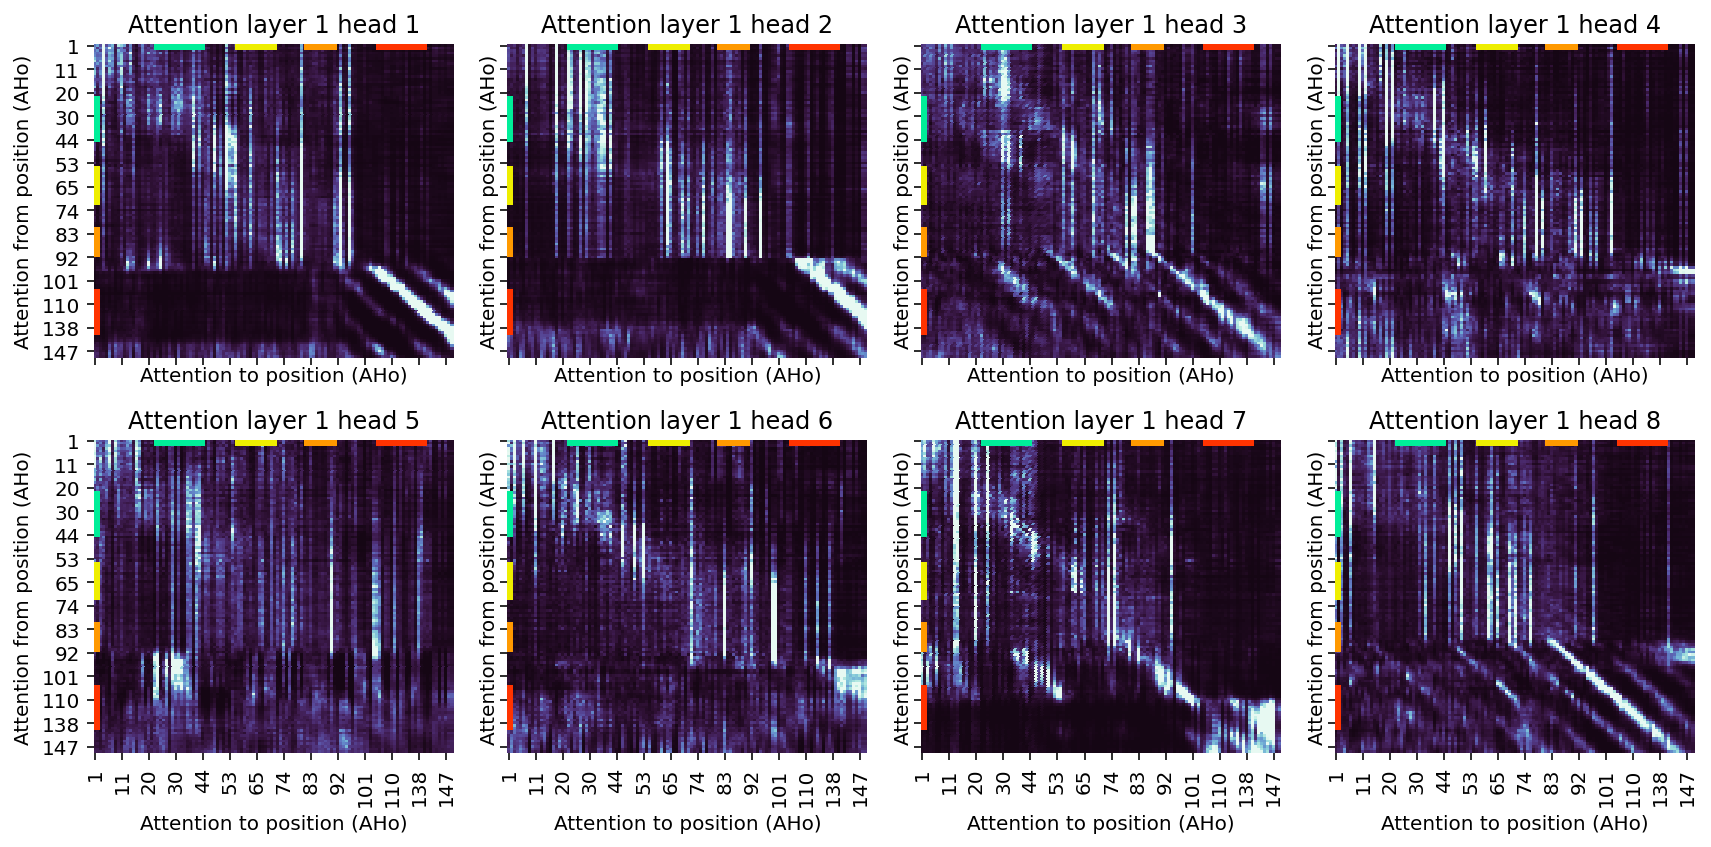

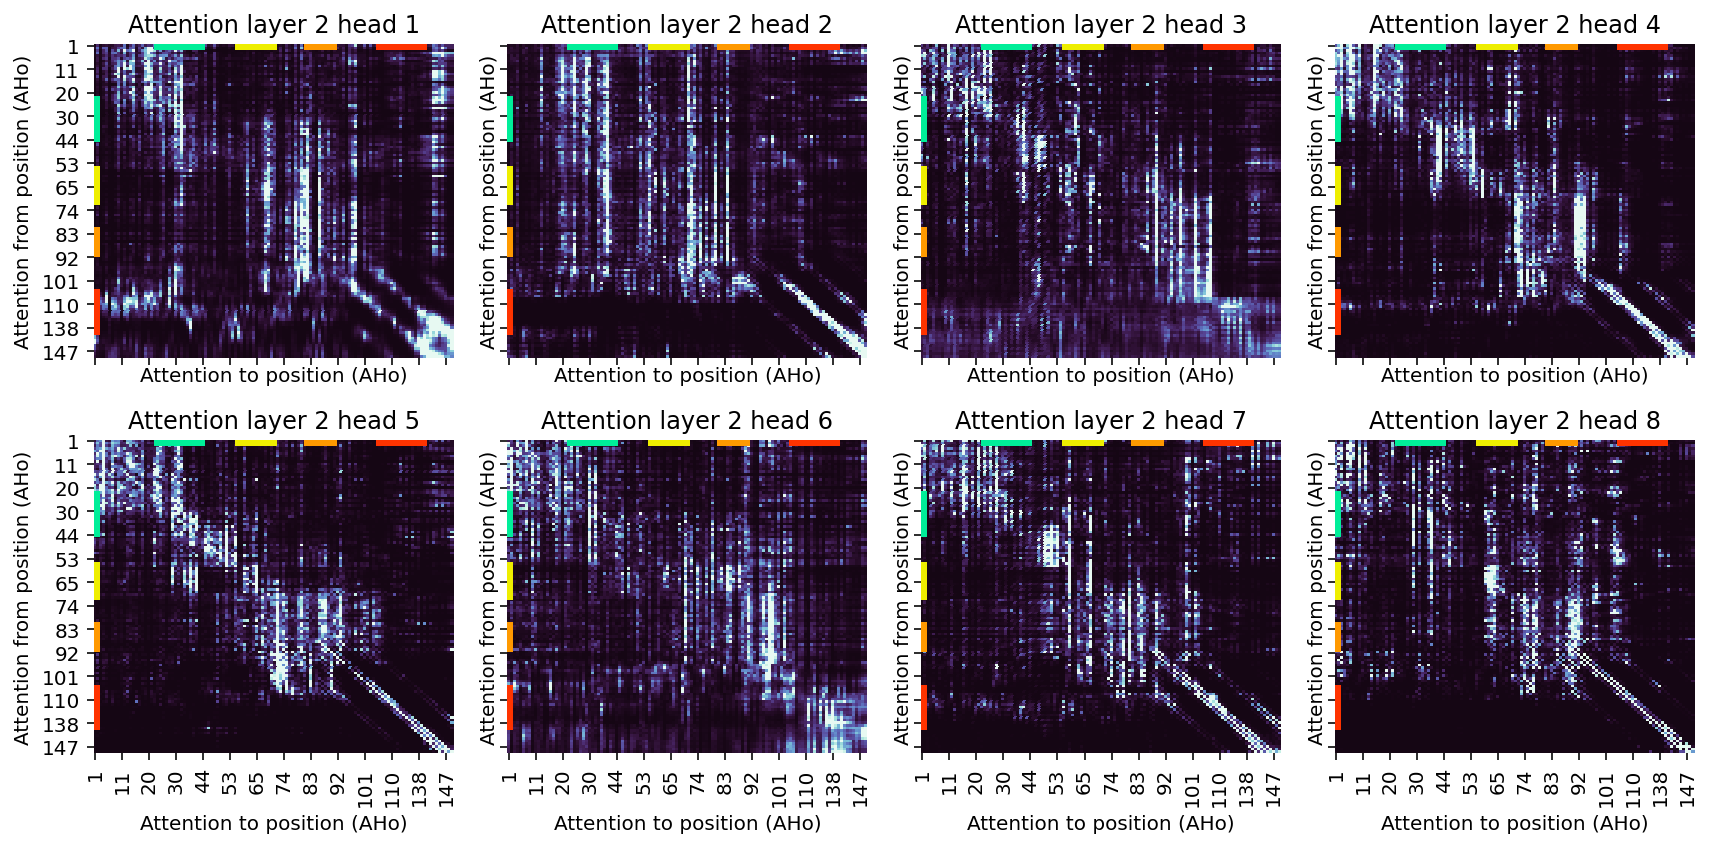

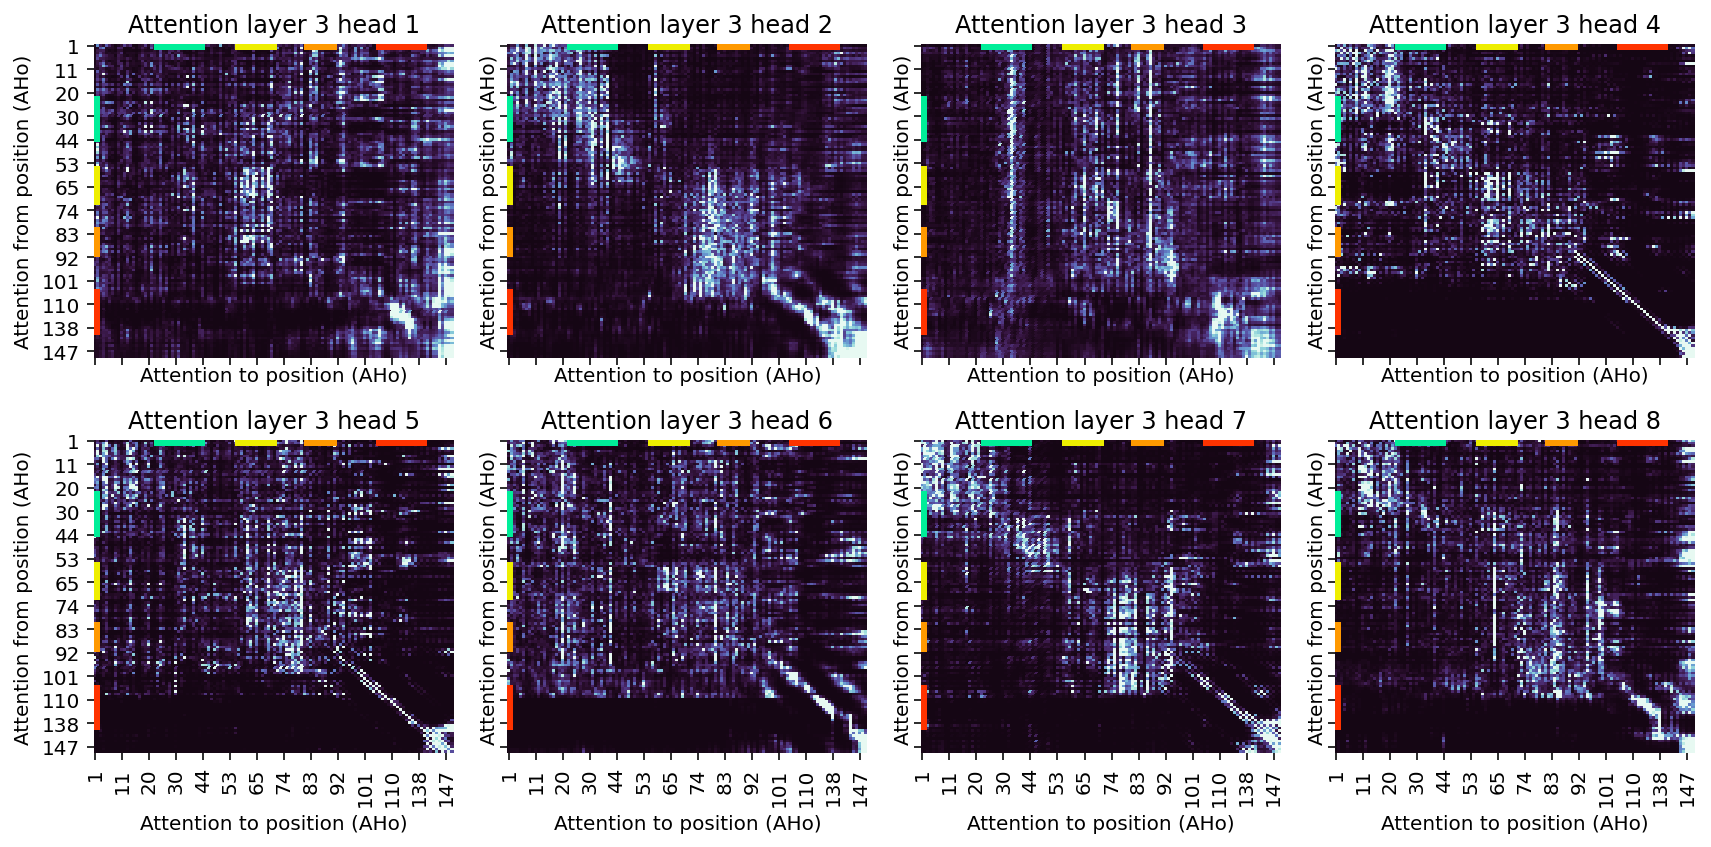

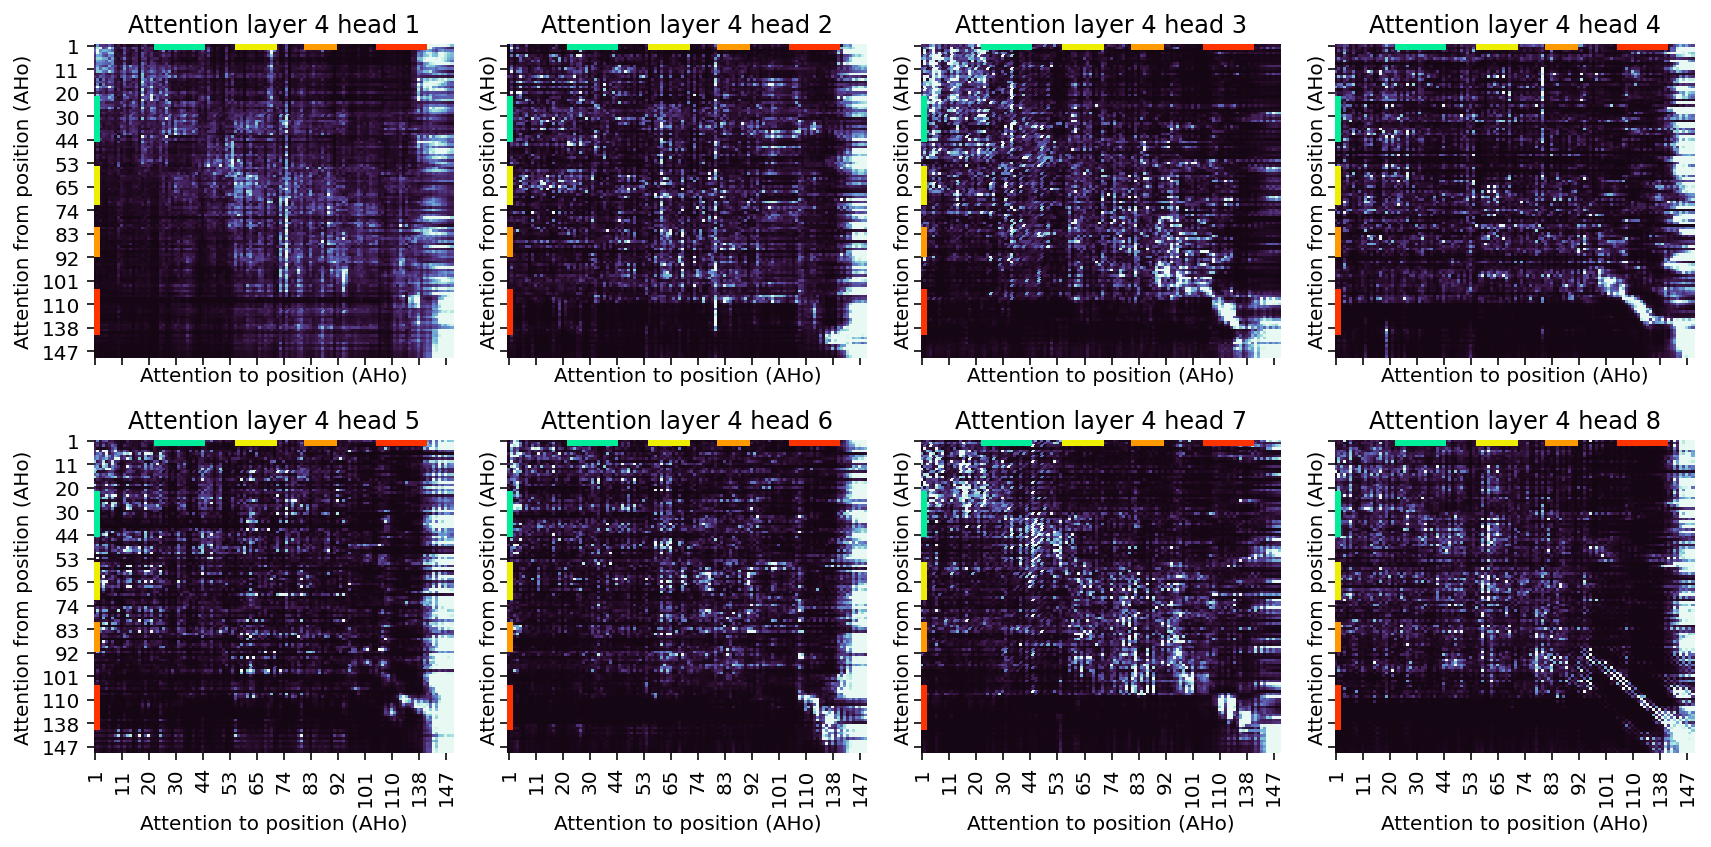

In [13]:
for layer, attn_layer in enumerate(attn_layers):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
    for i, attn in enumerate(attn_layer):
        ax = plot_attention_heatmap(attn, axes.flatten()[i], cbar=False, linewidth=6, text=False)
        ax.set_title(f'Attention layer {layer+1} head {i+1}')

    fig.tight_layout();
    plt.show()

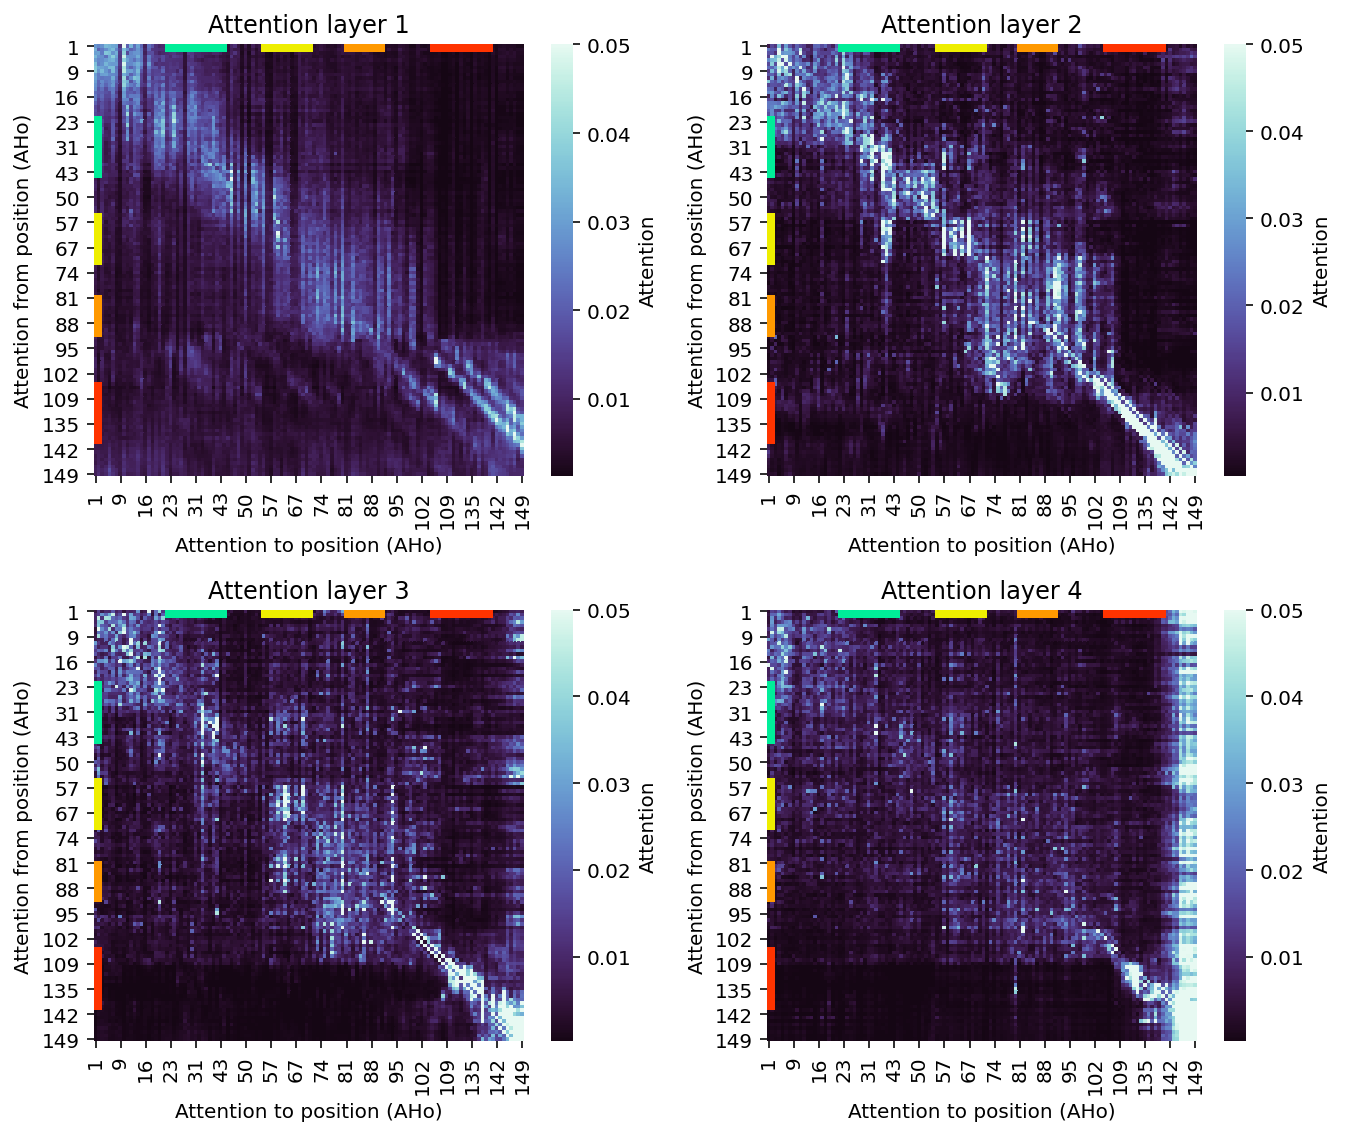

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(9.5, 8))
for layer, attn_layer in enumerate(attn_layers):
    ax = plot_attention_heatmap(attn_layer.mean(axis=0), ax=axes.flatten()[layer], text=False)
    ax.set_title(f'Attention layer {layer+1}')

fig.tight_layout();
plt.show()

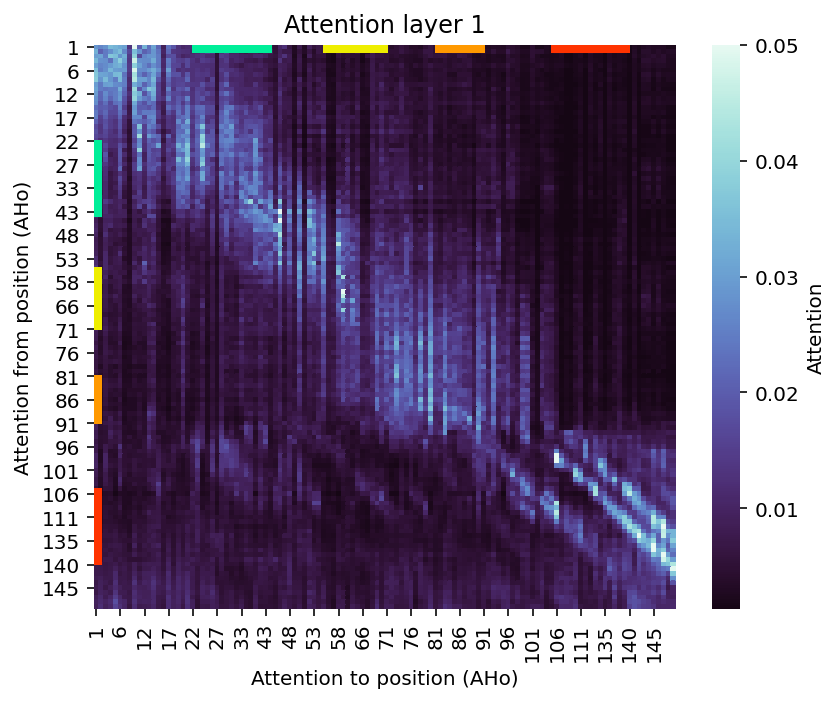

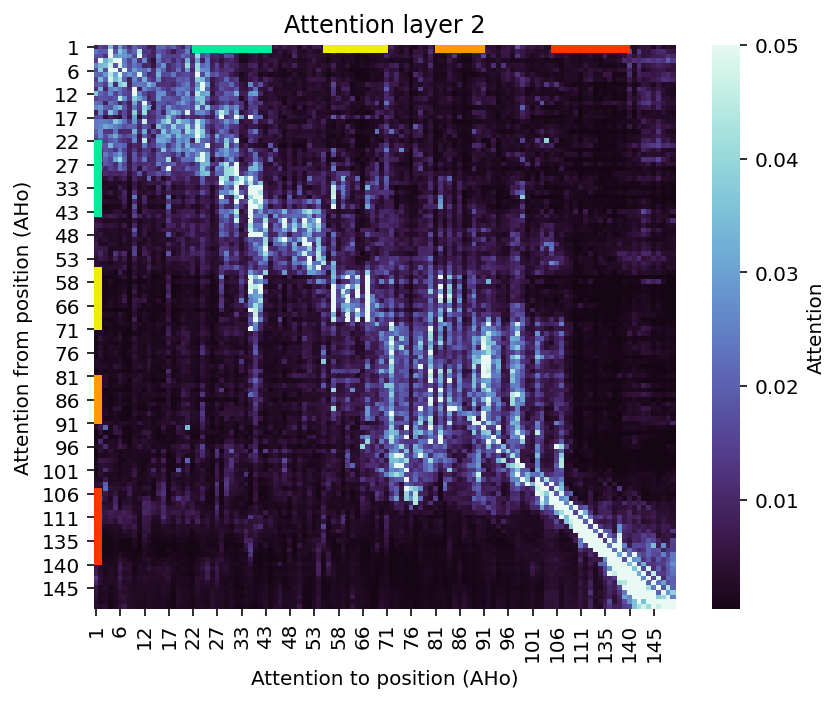

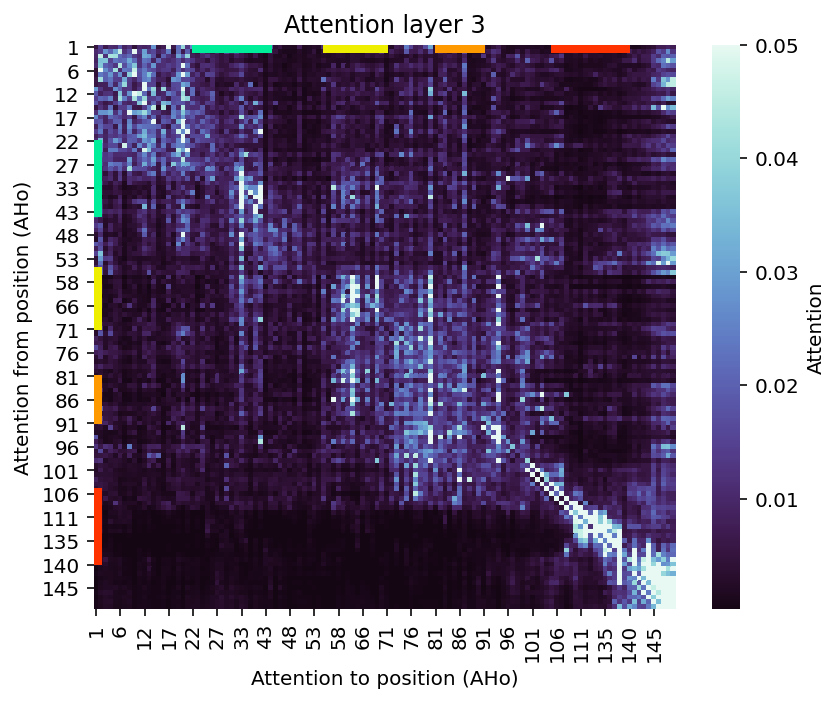

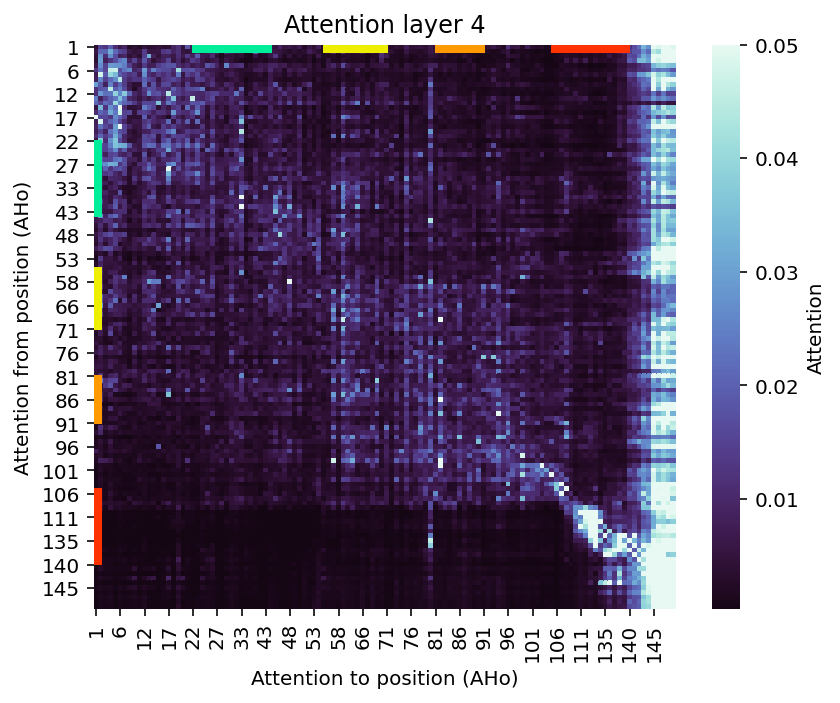

In [15]:
for layer, attn_layer in enumerate(attn_layers):
    fig, ax = plt.subplots(figsize=(6, 5))
    ax = plot_attention_heatmap(attn_layer.mean(axis=0), ax=ax, text=False)
    ax.set_title(f'Attention layer {layer+1}')

    fig.tight_layout();
    plt.show()

In [16]:
distances = np.zeros(shape=(len(POSITIONS), len(POSITIONS)))
for i in range(len(distances)):
    for j in range(len(distances)):
        distances[i][j] = np.linalg.norm(residues[i]['CA'].coord - residues[j]['CA'].coord)
distances = pd.DataFrame(distances, POSITIONS, POSITIONS)
distances.head()

,1,2,3,4,5,6,7,9,10,11,...,140,141,142,143,144,145,146,147,148,149
1,0.000000,3.805303,6.324516,10.080554,12.213276,15.891262,19.012957,21.358402,24.312981,27.159660,...,13.406110,14.954030,18.372311,20.946814,24.395267,27.205839,30.727699,33.910938,36.922501,40.380344
2,3.805303,0.000000,3.792464,7.100624,10.041476,13.405611,16.821287,19.442757,22.243454,24.815790,...,10.413154,12.649230,15.727755,18.361166,21.915203,24.515274,28.133698,31.155220,34.338448,37.824810
3,6.324516,3.792464,0.000000,3.791953,6.287017,9.750308,13.130543,15.657924,18.492006,21.120153,...,7.431505,9.426434,12.457450,14.835149,18.412729,21.026905,24.627665,27.702995,30.807590,34.255459
4,10.080554,7.100624,3.791953,0.000000,3.812069,6.447675,10.048882,12.851407,15.548947,17.846767,...,4.691167,7.370712,9.582160,11.614450,15.323715,17.630428,21.322660,24.233740,27.453503,30.870108
5,12.213276,10.041476,6.287017,3.812069,0.000000,3.786237,6.888497,9.443975,12.474627,15.029005,...,5.616971,6.515970,8.413306,9.554049,13.177701,15.545702,19.122534,22.168850,25.149109,28.453304


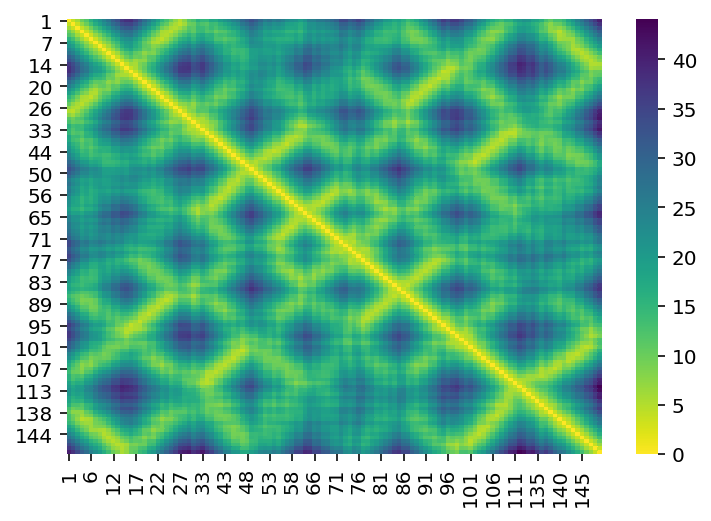

In [17]:
sns.heatmap(distances, cmap='viridis_r');

In [64]:
def plot_position(attn, positions, min_attention, attn_color = [0, 0.7, 1]):
    if isinstance(positions, str):
        positions = [positions]
    if isinstance(positions, int):
        raise ValueError('Positions should be strings (AHo)')
    seq_preview = seq[:-5]
    print(''.join(['↓' if pos in positions else ' ' for pos in POSITIONS[:len(seq_preview)]]))
    print(Chain(seq_preview, 'aho', 'north').format(numbering=True))
    view = nglview.show_biopython(model['B'])
    view.stage.set_parameters(**{
        "backgroundColor": "black",
        "fogNear": 40, "fogFar": 70
    })
    
    
    view.add_structure(BiopythonStructure(model['A']))
    for i, pos in enumerate(POSITIONS):
        if pos not in positions:
            continue
        for j in range(len(POSITIONS)):
            a = attn[i][j]
            coords_from = residues[i]['CA'].coord.tolist()
            coords_to = residues[j]['CA'].coord.tolist()
            if a >= min_attention:
                view.shape.add_cylinder(coords_from, coords_to, attn_color, 0.01+a*3)
    return view

In [19]:
layer2_attn = attn_layers[1].mean(axis=0)

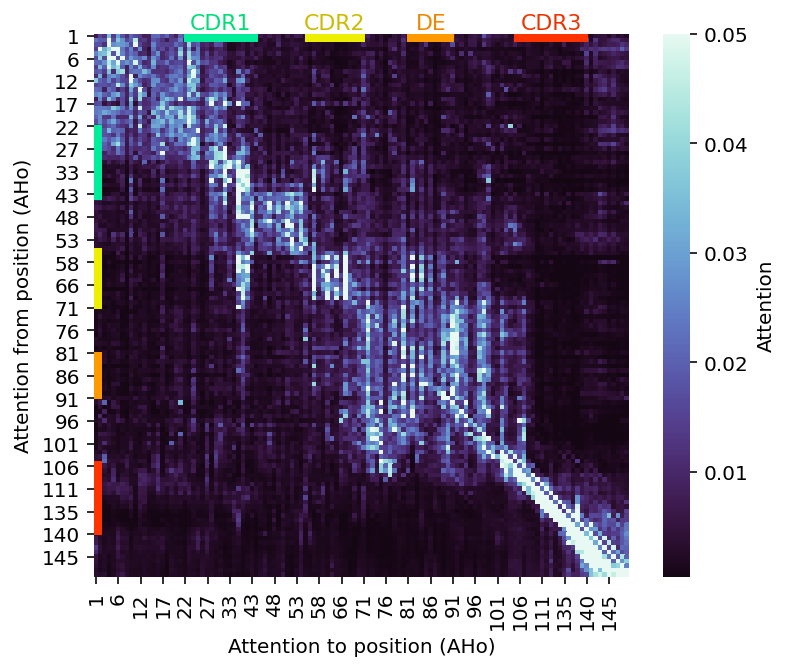

In [218]:
fig, ax = plt.subplots(figsize=(6, 5))
plot_attention_heatmap(layer2_attn, ax=ax);

#ax.axhline(POSITIONS.index('59'), lw=1.5, color='blue')
fig.savefig('../../data/figures/main/fig4a.png', dpi=300, bbox_inches='tight')

In [208]:
plot_position(layer2_attn, '29', min_attention=0.02)

                          ↓                                                                                        
0       1         2        3    4         5         6      7         8         9         10        11  13     14   
1234567901234567890123456790123901234567890123456789015678901234567890123456789012345678901234567890123345678901234
QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEWMGGINPSNGGTNFNEKFKNRVTLTTDSSTTTAYMELKSLQFDDTAVYYCARRDYRFDMGFDYWGQGTT
                      ^^^^^^^^^^^^^              ^^^^^^^^^^                                     ^^^^^^^^^^^^^      


NGLWidget()

In [67]:
view = plot_position(layer2_attn, '59', min_attention=0.02)
view.update_representation(component=0, quality='custom', subdiv=32)
view.update_representation(component=1, quality='custom', subdiv=32)
view

                                                   ↓                                                               
0       1         2        3    4         5         6      7         8         9         10        11  13     14   
1234567901234567890123456790123901234567890123456789015678901234567890123456789012345678901234567890123345678901234
QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEWMGGINPSNGGTNFNEKFKNRVTLTTDSSTTTAYMELKSLQFDDTAVYYCARRDYRFDMGFDYWGQGTT
                      ^^^^^^^^^^^^^              ^^^^^^^^^^                                     ^^^^^^^^^^^^^      


NGLWidget()

In [70]:
view = plot_position(layer2_attn, '59', min_attention=0.02)
view.update_representation(component=0, opacity=0)
view.update_representation(component=1, opacity=0)
view.add_surface(component=0, quality='custom', subdiv=32)
view.add_surface(component=1, quality='custom', subdiv=32)
view

                                                   ↓                                                               
0       1         2        3    4         5         6      7         8         9         10        11  13     14   
1234567901234567890123456790123901234567890123456789015678901234567890123456789012345678901234567890123345678901234
QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEWMGGINPSNGGTNFNEKFKNRVTLTTDSSTTTAYMELKSLQFDDTAVYYCARRDYRFDMGFDYWGQGTT
                      ^^^^^^^^^^^^^              ^^^^^^^^^^                                     ^^^^^^^^^^^^^      


NGLWidget()

In [61]:
view = plot_position(layer2_attn, '59', min_attention=0.02)
view.update_representation(component=0, quality='custom', subdiv=32, opacity=0)
view.update_representation(component=1, quality='custom', subdiv=32, opacity=0)
view.add_backbone(component=0, radius=0.05)
view.add_backbone(component=1, radius=0.05)
view

                                                   ↓                                                               
0       1         2        3    4         5         6      7         8         9         10        11  13     14   
1234567901234567890123456790123901234567890123456789015678901234567890123456789012345678901234567890123345678901234
QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEWMGGINPSNGGTNFNEKFKNRVTLTTDSSTTTAYMELKSLQFDDTAVYYCARRDYRFDMGFDYWGQGTT
                      ^^^^^^^^^^^^^              ^^^^^^^^^^                                     ^^^^^^^^^^^^^      


NGLWidget()

In [70]:
plot_position(layer2_attn, '60', min_attention=0.02)

                                                    ↓                                                              
0       1         2        3    4         5         6      7         8         9         10        11  13     14   
1234567901234567890123456790123901234567890123456789015678901234567890123456789012345678901234567890123345678901234
QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEWMGGINPSNGGTNFNEKFKNRVTLTTDSSTTTAYMELKSLQFDDTAVYYCARRDYRFDMGFDYWGQGTT
                      ^^^^^^^^^^^^^              ^^^^^^^^^^                                     ^^^^^^^^^^^^^      


NGLWidget()

In [79]:
plot_position(layer2_attn, 101, min_attention=0.05)

                                                                                                     ↓             
QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEWMGGINPSNGGTNFNEKFKNRVTLTTDSSTTTAYMELKSLQFDDTAVYYCARRDYRFDMGFDYWGQGTT
 °                        °°°°^^^^^           °°°^^^^^^^^^^^^^^^^^ ° ° ° °    °                 °°^^^^^^^^^^^°     


NGLWidget()